In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
%timeit sequences_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/evidence-6-oct.txt', sep='\\t', engine='python')

22.1 s ± 583 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
# remove decoys, which are indicated by a '+' in the Reverse column, and features with no intensity
sequences_df = sequences_df[pd.isna(sequences_df.Reverse) & (sequences_df.Intensity > 0)]

In [4]:
sequences_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [5]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [6]:
sequences_df[unique_peptide_key].sample(n=10)

,Sequence,Modifications,Charge
598904,VMVQPINLIFR,Unmodified,2
232433,HGNQYIQVNEPWK,Unmodified,2
97096,DSAQNSVIIVDK,Unmodified,2
492103,SGQPVTADDLGVTGALTVLMK,Unmodified,2
238790,HNLELTMAEMR,Unmodified,2
207920,GLLSELLHNCDGQLK,Unmodified,2
464232,QQNQEITDQLEEEK,Unmodified,2
594448,VLLGQDEPLIHVFAK,Unmodified,3
470666,RDGSDVIYPAR,Unmodified,2
453906,QGGDVLQNEEGETTSHLMGMFYR,Unmodified,3


In [7]:
sequences_df.Modifications.unique()

array(['Unmodified', 'Acetyl (Protein N-term)', 'Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', '2 Oxidation (M)',
       'Acetyl (Protein N-term),2 Oxidation (M)', '3 Oxidation (M)'],
      dtype=object)

In [8]:
sequences_df['Type'].unique()

array(['TIMS-MULTI-MSMS', 'TIMS-MULTI-MATCH'], dtype=object)

In [26]:
# unique peptides found across all runs
unique_peptides_count = len(sequences_df.drop_duplicates(subset=unique_peptide_key, keep='first', inplace=False))
unique_peptides_count

31324

In [27]:
sequences_df['group'] = sequences_df['Raw file'].apply(lambda x: x.split('_')[0])

#### analyse the YHE runs

In [28]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE211') | (sequences_df.group == 'YHE114')]

In [12]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(unique_peptide_key, as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df['Raw file'].unique())))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [13]:
number_of_yhe_runs_in_experiment = len(yhe_only_df['Raw file'].unique())
print('there are {} runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 21 runs in the experiment


In [14]:
# display the number of missing values in only the YHE runs
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values missing across the YHE runs.".format(round(proportion_of_missing_extractions*100)))

32.0% of values missing across the YHE runs.


In [29]:
modified_sequences_count_yhe_runs = len(yhe_sequence_occurences_df)
modified_sequences_count_yhe_runs

30182

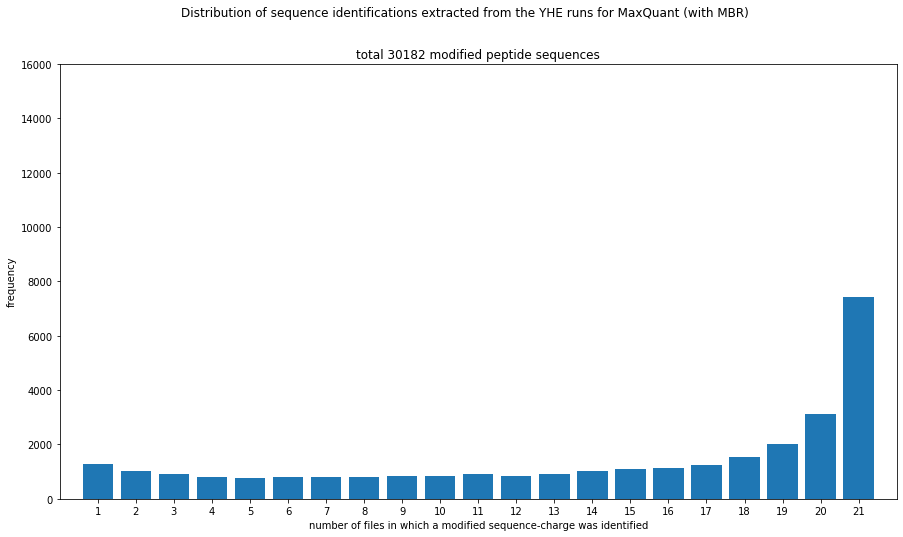

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications extracted from the YHE runs for MaxQuant (with MBR)')
plt.title('total {} modified peptide sequences'.format(modified_sequences_count_yhe_runs))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
plt.ylim((0,16000))

plt.show()

#### analyse the human-only runs

In [17]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')].copy()

In [18]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_df.groupby(unique_peptide_key, as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df['Raw file'].unique())))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [19]:
number_of_human_runs_in_experiment = len(human_only_df['Raw file'].unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 human-only runs in the experiment


In [20]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values missing across the experiment.".format(round(proportion_of_missing_extractions*100)))

29.0% of values missing across the experiment.


In [32]:
unique_sequences_human_df = human_only_df.drop_duplicates(subset=unique_peptide_key, keep='first', inplace=False).copy()
len(unique_sequences_human_df)

23890

In [33]:
# how many are not human?
unique_sequences_human_df['human'] = unique_sequences_human_df['Proteins'].str.contains('HUMAN')

In [34]:
unique_sequences_human_df.human.value_counts()

True     22368
False     1522
Name: human, dtype: int64

In [35]:
print('false positives: {}%'.format(round(len(unique_sequences_human_df[(unique_sequences_human_df.human == False)]) / len(unique_sequences_human_df) * 100.0, 1)))

false positives: 6.4%


In [36]:
modified_sequences_count_human_runs = len(human_sequence_occurences_df)
modified_sequences_count_human_runs

23890

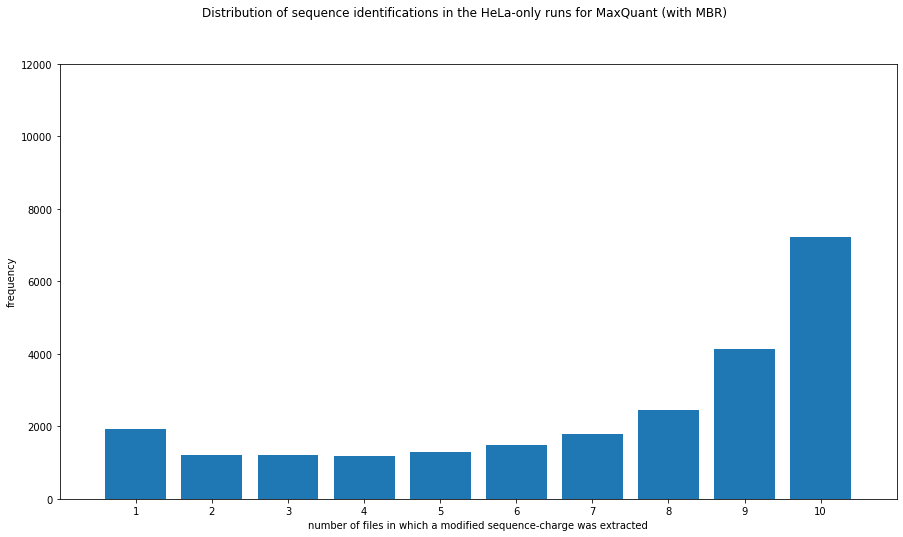

In [25]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for MaxQuant (with MBR)')
# plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
plt.ylim((0,12000))

plt.show()